In [1]:
skip_training = False
save_all = True

In [2]:
import os
if os.path.isdir('../data'):
    data_dir = '../data'
else:
    raise NotImplementedError()
print('The data directory is %s' % data_dir)

The data directory is ../data


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Function

In [4]:
device = torch.device('cpu')

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root=data_dir+"/cifar-10/train", 
                                        train=True,
                                        download=True, 
                                        transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

testset = torchvision.datasets.CIFAR10(root=data_dir+"/cifar-10/test", 
                                       train=False,
                                       download=True, 
                                       transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False)

classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [6]:
def convert_to_imshow_format(image):
    # first convert back to [0,1] range from [-1,1] range
    image = image / 2 + 0.5
    image = image.numpy()
    # convert from CHW to HWC
    # from 3x32x32 to 32x32x3
    return image.transpose(1,2,0)

def plot_images(images, n_rows=1):
    fig, axes = plt.subplots(n_rows, len(images) // n_rows, figsize=(2*len(images)//n_rows,2.25*n_rows))
    for idx, image in enumerate(images):
        ax_ind = (idx%n_rows,idx//n_rows)
        if n_rows is 1:
            ax_ind = idx
        axes[ax_ind].imshow(convert_to_imshow_format(image))
        axes[ax_ind].set_title(classes[labels[idx]])
        axes[ax_ind].set_xticks([])
        axes[ax_ind].set_yticks([])
    #fig, axs = plt.subplots(n_rows, images.size(0) // n_rows)
    #for ax, img in zip(axs.flat, images):
    #    ax.matshow(img[0].cpu().numpy(), cmap=plt.cm.Greys)
    #    ax.set_xticks([])
    #    ax.set_yticks([])
    #    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    #plt.tight_layout(w_pad=0)

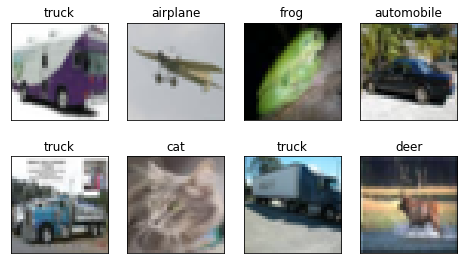

In [7]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
plot_images(images[:8], n_rows=2)

In [8]:
class FiftyFiftyMaxAvgPool2d(nn.Module):
    def __init__(self, kernel_size, stride=None, padding=0):
        super(FiftyFiftyMaxAvgPool2d, self).__init__()
        self.avg = nn.AvgPool2d(kernel_size, stride=stride, padding=padding)
        self.max = nn.MaxPool2d(kernel_size, stride=stride, padding=padding)#, return_indices=True)
        #self.a = nn.Linear(1,1,bias=False)
        self.alpha = torch.tensor([0.5]) #nn.Linear(1, 1, bias=False)
    
    def forward(self, x):
        #alpha = torch.clamp(self.a(torch.ones(1)), min=0, max=1).unsqueeze(0)
        alpha = torch.clamp(self.alpha, min=0, max=1)
        return (alpha * self.max.forward(x) + (1-alpha) * self.avg.forward(x))
        #return MixerFunction.apply(x, self.alpha)#, self.avg, self.max)


In [9]:
class MinPool2d(nn.Module):
    def __init__(self, kernel_size, stride=None, padding=0):
        super(MinPool2d, self).__init__()
        self.max = nn.MaxPool2d(kernel_size, stride=stride, padding=padding)#, return_indices=True)
    
    def forward(self, x):
        return -self.max(-x)


In [10]:
class MixerFunction(Function):
    @staticmethod
    def forward(ctx, x, alpha, kernel_size, stride):
        avg_forward = F.avg_pool2d(x, kernel_size, stride)
        max_forward, max_ind = F.max_pool2d(x, kernel_size, stride, return_indices=True)
        kernel_size = torch.tensor([kernel_size])
        stride = torch.tensor([stride])
        ctx.save_for_backward(x, alpha, max_forward, avg_forward, max_ind, kernel_size, stride)
        return alpha * max_forward + (1-alpha) * avg_forward
    
    
    @staticmethod
    def backward(ctx, dy):
        x, alpha, max_forward, avg_forward,max_ind, kernel_size, stride = ctx.saved_tensors
        kernel_size = kernel_size.item()
        stride = stride.item()
        grad_input = grad_alpha = None
        
        if ctx.needs_input_grad[0]:
            grad_avg = F.interpolate(dy, scale_factor=stride, mode='nearest')
            grad_avg = grad_avg*1.0/(stride*stride)
            #grad_max = F.max_unpool2d(dy, max_ind, kernel_size,stride)#,output_size = x.shape)
            #print(grad_max.shape)
            grad_max = torch.zeros(x.shape).view(1,-1).squeeze(0)
            grad_max[max_ind] = dy#.view(1, -1)
            grad_max = grad_max.view(x.shape)
            grad_input = (alpha * grad_max + (1-alpha)*grad_avg)
            #print(grad_input)
        if ctx.needs_input_grad[1]:
            #print(dy.shape)
            #print(max_forward.shape)
            grad_alpha = (dy * (avg_forward - max_forward))#.sum(-1).sum(-1)
            #print(grad_alpha.shape)
            #print(grad_alpha)
            #print(max_forward - avg_forward)
            
        return grad_input, grad_alpha, None, None
    
    
class MixedMaxAvgPool2d(nn.Module):
    def __init__(self, kernel_size, stride=None, padding=0):
        super(MixedMaxAvgPool2d, self).__init__()
        self.stride = stride
        self.kernel = kernel_size
        self.avg = nn.AvgPool2d(kernel_size, stride=stride, padding=padding)
        self.max = nn.MaxPool2d(kernel_size, stride=stride, padding=padding)#, return_indices=True)
        #self.a = nn.Linear(1,1,bias=False)
        self.alpha = nn.Parameter(torch.rand(1, requires_grad=True)) #nn.Linear(1, 1, bias=False)
    
    #def parameters(self):
    #    return [self.alpha]
    
    def forward(self, x):
        #alpha = torch.clamp(self.a(torch.ones(1)), min=0, max=1).unsqueeze(0)
        alpha = torch.clamp(self.alpha, min=0, max=1)
        #return (alpha * self.max.forward(x) + (1-alpha) * self.avg.forward(x))
        return MixerFunction.apply(x, self.alpha, self.kernel, self.stride)#, self.avg, self.max)
    

In [11]:
# Let us test the shapes
x = torch.tensor([[1.0,-1.0,1.0,-1.0],[0,0,0,0],[1.0,-1.0,1.0,-1.0],[0,0,0,0]], requires_grad=True).unsqueeze(0).unsqueeze(0)
#print(x.shape)
act_fn = MixedMaxAvgPool2d(2,2)
print(act_fn.alpha)
lin = nn.Linear(4,1,bias=False)
lin.weight.data.fill_(0.25)
criterion = nn.MSELoss()
optimizer = optim.SGD(act_fn.parameters(), lr=0.001, momentum=0.9)

# zero the parameter gradients
optimizer.zero_grad()

# forward + backward + optimize
y = act_fn.forward(x)
#print(y)
#print(y.shape)
#print(torch.ones([1,1]).shape)
y = lin.forward(y.view(4)).unsqueeze(0)

#print(y)
#print(y.shape)
z = torch.tensor([1.0])

loss = criterion(y, z)
loss.backward()
optimizer.step()
print(act_fn.alpha)

#dy = torch.ones(1,1,1).unsqueeze(0)
#dx = act_fn.backward(dy)
#assert dx.shape == x.shape, "Bad shape of dx: dx.shape={}, x.shape={}".format(dx.shape, x.shape)
#print("The shapes seem to be ok.")

Parameter containing:
tensor([0.2076], requires_grad=True)
Parameter containing:
tensor([0.2060], requires_grad=True)


## ResNet

Let us train a network with an architecure inspired by [ResNet](https://arxiv.org/pdf/1512.03385.pdf).

### ResNet block
Our ResNet consists of blocks with two convolutional layers and a skip connection.

In the most general case, our implementation should have:

<img src="resnet_block_04.png" width=220 style="float: right;">

* Two convolutional layers with:
    * 3x3 kernel
    * no bias terms
    * padding with one pixel on both sides
    * 2d batch normalization after each convolutional layer.

* **The first convolutional layer also (optionally) has:**
    * different number of input channels and output channels
    * change of the resolution with stride.

* The skip connection:
    * simply copies the input if the resolution and the number of channels do not change.
    * If either the resolution or the number of channels change, the skip connection should have one convolutional layer with:
        * 1x1 convolution **without bias**
        * change of the resolution with stride (optional)
        * different number of input channels and output channels (optional)
    * If either the resolution or the number of channels change, the 1x1 convolutional layer is followed by 2d batch normalization.

* The ReLU nonlinearity is applied after the first convolutional layer and at the end of the block.

**Note: Batch normalization is expected to be right after a convolutional layer.**

<img src="resnet_blocks_123.png" width=650 style="float: top;">

The implementation should also handle specific cases such as:

Left: The number of channels and the resolution do not change.
There are no computations in the skip connection.

Middle: The number of channels changes, the resolution does not change.

Right: The number of channels does not change, the resolution changes.

In [12]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        """
        Args:
          in_channels (int):  Number of input channels.
          out_channels (int): Number of output channels.
          stride (int):       Controls the stride.
        """
        super(Block, self).__init__()
        # YOUR CODE HERE
        #raise NotImplementedError()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, bias = False, padding = 1, stride = stride),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, bias = False, padding = 1),
            nn.BatchNorm2d(out_channels),
        )
        
        self.skip = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, bias = False, padding = 1, stride = stride),
            nn.BatchNorm2d(out_channels),
        )
        if in_channels == out_channels and stride == 1:
            self.skip = None

    def forward(self, x):
        # YOUR CODE HERE
        #raise NotImplementedError()
        skip = x if self.skip is None else self.skip(x)
        x = self.net(x)
        x = x.add(skip) #torch.cat([x, skip], 1)
        return nn.functional.relu(x)

In [13]:
# Test your implementation of the Block

# The number of channels and resolution do not change
batch_size = 20
x = torch.zeros(batch_size, 16, 28, 28)
block = Block(in_channels=16, out_channels=16)
y = block(x)
assert y.shape == torch.Size([batch_size, 16, 28, 28]), "Bad shape of y: y.shape={}".format(y.shape)

# Increase the number of channels
block = Block(in_channels=16, out_channels=32)
y = block(x)
assert y.shape == torch.Size([batch_size, 32, 28, 28]), "Bad shape of y: y.shape={}".format(y.shape)

# Decrease the resolution
block = Block(in_channels=16, out_channels=16, stride=2)
y = block(x)
assert y.shape == torch.Size([batch_size, 16, 14, 14]), "Bad shape of y: y.shape={}".format(y.shape)

# Increase the number of channels and decrease the resolution
block = Block(in_channels=16, out_channels=32, stride=2)
y = block(x)
assert y.shape == torch.Size([batch_size, 32, 14, 14]), "Bad shape of y: y.shape={}".format(y.shape)

print('The shapes seem to be ok.')

The shapes seem to be ok.


### Group of blocks

ResNet consists of several groups of blocks. The first block in a group may change the number of channels (often multiples the number by 2) and subsample (using strides).

<img src="resnet_group.png" width=500 style="float: left;">

In [14]:
# Let us implement a group of blocks in this cell
class GroupOfBlocks(nn.Module):
    def __init__(self, in_channels, out_channels, n_blocks, stride=1):
        super(GroupOfBlocks, self).__init__()

        first_block = Block(in_channels, out_channels, stride)
        other_blocks = [Block(out_channels, out_channels) for _ in range(1, n_blocks)]
        self.group = nn.Sequential(first_block, *other_blocks)

    def forward(self, x):
        return self.group(x)

In [15]:
# Let's test it
group = GroupOfBlocks(in_channels=10, out_channels=20, n_blocks=3)
print(group)

GroupOfBlocks(
  (group): Sequential(
    (0): Block(
      (net): Sequential(
        (0): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (skip): Sequential(
        (0): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Block(
      (net): Sequential(
        (0): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(20, 20, kernel_size=(3, 3), stride=(

### ResNet

Let us mplement a ResNet with the following architecture. It contains three groups of blocks, each group having two basic blocks.

<img src="resnet.png" width=900 style="float: left;">

In [16]:
class ResNet(nn.Module):
    def __init__(self, n_blocks, n_channels=64, num_classes=10, pools=None):
        """
        Args:
          n_blocks (list):   A list with three elements which contains the number of blocks in 
                             each of the three groups of blocks in ResNet.
                             For instance, n_blocks = [2, 4, 6] means that the first group has two blocks,
                             the second group has four blocks and the third one has six blocks.
          n_channels (int):  Number of channels in the first group of blocks.
          num_classes (int): Number of classes.
        """
        assert len(n_blocks) == 3, "The number of groups should be three."
        super(ResNet, self).__init__()
        if pools is None:
            pools = [nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
                     nn.AvgPool2d(kernel_size=4, stride=1)]
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n_channels, kernel_size=5, stride=1, padding=2, bias=False)
        self.bn1 = nn.BatchNorm2d(n_channels)
        self.relu = nn.ReLU(inplace=True)
        self.pool1 = pools[0]#nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # YOUR CODE HERE
        self.group1 = GroupOfBlocks(in_channels = n_channels, out_channels = n_channels, n_blocks = n_blocks[0])
        self.group2 = GroupOfBlocks(in_channels = n_channels, out_channels = 2*n_channels, n_blocks = n_blocks[1], stride=2)
        self.group3 = GroupOfBlocks(in_channels = 2*n_channels, out_channels = 4*n_channels, n_blocks = n_blocks[2], stride=2)
        #raise NotImplementedError()

        self.pool2 = pools[1]#nn.AvgPool2d(kernel_size=4, stride=1)
        self.fc = nn.Linear(4*n_channels, num_classes)

        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, np.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def forward(self, x, verbose=False):
        if verbose: print(x.shape)
        x = self.conv1(x)
        if verbose: print('conv1:  ', x.shape)
        x = self.bn1(x)
        if verbose: print('bn1:    ', x.shape)
        x = self.relu(x)
        if verbose: print('relu:   ', x.shape)
        x = self.pool1(x)
        if verbose: print('maxpool:', x.shape)

        # YOUR CODE HERE
        
        x = self.group1(x)
        if verbose: print('group 1:', x.shape)
        x = self.group2(x)
        if verbose: print('group 2:', x.shape)
        x = self.group3(x)
        if verbose: print('group 3:', x.shape)
        #raise NotImplementedError()

        x = self.pool2(x)
        if verbose: print('avgpool:', x.shape)

        x = x.view(-1, self.fc.in_features)
        if verbose: print('x.view: ', x.shape)
        x = self.fc(x)
        if verbose: print('out:    ', x.shape)

        return x

In [17]:
# Create a network with 2 block in each of the three groups
n_blocks = [2, 2, 2]  # number of blocks in the three groups
pools = [nn.LPPool2d(2, kernel_size=3, stride=2),
         nn.LPPool2d(2, kernel_size=4, stride=1)]
net = ResNet(n_blocks, n_channels=10, pools=pools)
net.to(device)

# Feed a batch of images from the training data to test the network
with torch.no_grad():
    dataiter = iter(trainloader)
    images, labels = dataiter.next()
    images = images.to(device)
    print('Shape of the input tensor:', images.shape)

    y = net.forward(images, verbose=True)
    print(y.shape)
    assert y.shape == torch.Size([32, 10]), "Bad shape of y: y.shape={}".format(y.shape)

print('The shapes to be ok.')

Shape of the input tensor: torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])
conv1:   torch.Size([32, 10, 32, 32])
bn1:     torch.Size([32, 10, 32, 32])
relu:    torch.Size([32, 10, 32, 32])
maxpool: torch.Size([32, 10, 15, 15])
group 1: torch.Size([32, 10, 15, 15])
group 2: torch.Size([32, 20, 8, 8])
group 3: torch.Size([32, 40, 4, 4])
avgpool: torch.Size([32, 40, 1, 1])
x.view:  torch.Size([32, 40])
out:     torch.Size([32, 10])
torch.Size([32, 10])
The shapes to be ok.


In [23]:
# This function computes the accuracy on the test dataset
def compute_accuracy(net, testloader):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

In [18]:
def train_model(net, n_epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.01)

    net.train()
    for epoch in range(n_epochs):
        running_loss = 0.0
        print_every = 200  # mini-batches
        for i, (inputs, labels) in enumerate(trainloader, 0):
            # Transfer to GPU
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if (i % print_every) == (print_every-1):
                print('[%d, %5d] loss: %.3f' % (epoch+1, i+1, running_loss/print_every))
                running_loss = 0.0

            if skip_training:
                break
        if skip_training:
            break

        # Print accuracy after every epoch
        accuracy = compute_accuracy(net, testloader)
        print('Accuracy of the network on the test images: %.3f' % accuracy)

    print('Finished Training')

In [19]:
def save_model(net, name):
    # Save the network to a file, submit this file together with your notebook
    filename = name
    if not skip_training:
        try:
            do_save = 'yes'
            if not save_all:
                do_save = input('Do you want to save the model (type yes to confirm)? ').lower()
            if do_save == 'yes':
                torch.save(net.state_dict(), filename)
                print('Model saved to %s' % filename)
            else:
                print('Model not saved')
        except:
            raise Exception('The notebook should be run or validated with skip_training=True.')
    else:
        net.load_state_dict(torch.load(filename, map_location=lambda storage, loc: storage))
        net.to(device)
        print('Model loaded from %s' % filename)

In [20]:
# Let us now train the ResNet using the same training loop
n_blocks = [2, 2, 2]  # number of blocks in the three groups
pools = [nn.LPPool2d(2, kernel_size=3, stride=2),
         nn.LPPool2d(2, kernel_size=4, stride=1)]
net = ResNet(n_blocks, n_channels=16, pools=pools)
net.to(device)
print('beep boop')

beep boop


In [21]:
n_epochs = 10

In [ ]:
train_model(net, n_epochs)
save_model(net, 'resnet_lp_pool.pth')
# Let us compute the accuracy on the test set
accuracy = compute_accuracy(net, testloader)
print('Accuracy of the network on the test images: %.3f' % accuracy)

[1,   200] loss: 1.249
[1,   400] loss: 1.183
[1,   600] loss: 1.165
[1,   800] loss: 1.110
[1,  1000] loss: 1.100
[1,  1200] loss: 1.073
[1,  1400] loss: 1.030
Accuracy of the network on the test images: 0.627
[2,   200] loss: 1.087
[2,   400] loss: 0.994
[2,   600] loss: 0.992
[2,   800] loss: 0.971
[2,  1000] loss: 0.952
[2,  1200] loss: 0.946
[2,  1400] loss: 0.933
Accuracy of the network on the test images: 0.653
[3,   200] loss: 0.859
[3,   400] loss: 0.863
[3,   600] loss: 0.829
[3,   800] loss: 0.835
[3,  1000] loss: 0.864
[3,  1200] loss: 0.828
[3,  1400] loss: 0.877
Accuracy of the network on the test images: 0.681
[4,   200] loss: 0.735
[4,   400] loss: 0.724
[4,   600] loss: 0.773
[4,   800] loss: 0.759
[4,  1000] loss: 0.780
[4,  1200] loss: 0.795
[4,  1400] loss: 0.781
Accuracy of the network on the test images: 0.704
[5,   200] loss: 0.657
[5,   400] loss: 0.709
[5,   600] loss: 0.706
[5,   800] loss: 0.700
[5,  1000] loss: 0.721
[5,  1200] loss: 0.695
[5,  1400] loss: 0

In [ ]:
# Let us now train the ResNet using the same training loop
n_blocks = [2, 2, 2]  # number of blocks in the three groups
pools = [nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
         nn.MaxPool2d(kernel_size=4, stride=1)]
net = ResNet(n_blocks, n_channels=16, pools=pools)
net.to(device)
print('beep boop')

In [ ]:
train_model(net, n_epochs)
save_model(net, 'resnet_max_pool.pth')
# Let us compute the accuracy on the test set
accuracy = compute_accuracy(net, testloader)
print('Accuracy of the network on the test images: %.3f' % accuracy)

In [ ]:
# Let us now train the ResNet using the same training loop
n_blocks = [2, 2, 2]  # number of blocks in the three groups
pools = [nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
         nn.MaxPool2d(kernel_size=4, stride=1)]
net = ResNet(n_blocks, n_channels=16, pools=pools)
net.to(device)
print('beep boop')

In [ ]:
train_model(net, n_epochs)
save_model(net, 'resnet_avg_pool.pth')
# Let us compute the accuracy on the test set
accuracy = compute_accuracy(net, testloader)
print('Accuracy of the network on the test images: %.3f' % accuracy)

In [ ]:
# Let us now train the ResNet using the same training loop
n_blocks = [2, 2, 2]  # number of blocks in the three groups
pools = [FiftyFiftyMaxAvgPool2d(3, stride=2, padding=1),
         FiftyFiftyMaxAvgPool2d(4, stride=1)]
net = ResNet(n_blocks, n_channels=16, pools=pools)
net.to(device)
print('beep boop')

In [ ]:
train_model(net, n_epochs)
save_model(net, 'resnet_5050_pool.pth')
# Let us compute the accuracy on the test set
accuracy = compute_accuracy(net, testloader)
print('Accuracy of the network on the test images: %.3f' % accuracy)

In [ ]:
# Let us now train the ResNet using the same training loop
n_blocks = [2, 2, 2]  # number of blocks in the three groups
pools = [MixedMaxAvgPool2d(3, stride=2, padding=1),
         MixedMaxAvgPool2d(4, stride=1)]
net = ResNet(n_blocks, n_channels=16, pools=pools)
net.to(device)
print('beep boop')

In [ ]:
train_model(net, n_epochs)
save_model(net, 'resnet_mixed-max-avg_pool.pth')
# Let us compute the accuracy on the test set
accuracy = compute_accuracy(net, testloader)
print('Accuracy of the network on the test images: %.3f' % accuracy)

In [ ]:
# Let us now train the ResNet using the same training loop
n_blocks = [2, 2, 2]  # number of blocks in the three groups
pools = [MinPool2d(3, stride=2, padding=1),
         MinPool2d(4, stride=1)]
net = ResNet(n_blocks, n_channels=16, pools=pools)
net.to(device)
print('beep boop')

In [ ]:
train_model(net, n_epochs)
save_model(net, 'resnet_mixed-max-avg_pool.pth')
# Let us compute the accuracy on the test set
accuracy = compute_accuracy(net, testloader)
print('Accuracy of the network on the test images: %.3f' % accuracy)